In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import whitw
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
import pandas as pd
import math

In [3]:
def potential(phi):
    return 0.5*phi**2 * M**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return phi * M**2    

In [4]:
def GetXi(dphidt, Iterm, H):
    #print("H: ", H, "  dphidt: ", dphidt)
    return Iterm * dphidt / (2*H)

def GetS(a, H, sigma):
    #print(H)
    return a**(alpha) * sigma / (2*H)

In [5]:
def BoundaryComputations(kh, dphidt, ddphiddt, Iterm, I2term, a, H, ntr, sigma=0, dsigmadt=0, approx=False):
    xi = GetXi(dphidt, Iterm, H)
    s = GetS(a, H, sigma)
    #print(np.sqrt(xi**2))
    #print(xi)
    r = (abs(xi) + np.sqrt(xi**2 + s**2 + s))
    f = a**(1-alpha) * H * (r)
    """fprime =  a*(1-alpha) * ( (1-alpha) * H**2 * f + 
                            0.5 * ( (I2term * dphidt**2 + Iterm*ddphiddt) * g(Iterm*dphidt) 
                                    + 1/np.sqrt(Iterm**2 * dphidt**2 + a**(2*alpha)*(sigma**2 + 2*H*sigma)) *
                                  (Iterm*I2term*dphidt**3 + Iterm**2*dphidt*ddphiddt 
                                   + a**(2*alpha) * (sigma * (alpha*H*sigma + dsigmadt) 
                                                     + a**(-alpha)*H * (2*alpha*sigma + dsigmadt))) ))"""
    
    def g(x):
        if (x < 0):
            return -1
        elif (x > 0):
            return 1
        else:
            #print("a miracle")
            return 0
    
    if (sigma==0):
        fprime = (1-alpha)*H*f + a**(1-alpha)*(I2term*dphidt**2 + Iterm*ddphiddt)*g(xi)
        #fprime = kh*H
    else:
        #approximation: dHdt = alphaH**2 (slow-roll)
        fprime = ((1-alpha)*H*f 
                  + a**(1-alpha)*(I2term*dphidt**2/2 + Iterm*ddphiddt/2)*(g(xi) + xi/np.sqrt(xi**2 + s**2 + s))
                  + a*(alpha*H*sigma + dsigmadt)*(s + 1/2)/(2*np.sqrt(xi**2 + s**2 + s))
                  + a**(1-alpha)*H**2*alpha*s/(2*np.sqrt(xi**2 + s**2 + s)))        
    
    if (fprime >= 0):
        if ((kh-f)/kh <= 1e-3):
            dlnkhdt = fprime/kh
        else:
            dlnkhdt = 0
            #dlnkhdt = H
    else:
        dlnkhdt = 0
        
    bdrF = ComputeBoundary(a, kh, dlnkhdt, ntr, r, xi, s, approx)
    
    return dlnkhdt, bdrF
    

In [6]:
def ComputeBoundary(a, kh, dlnkhdt, ntr, r, xi, s, approx=False):
    
    if (s==0):
        delta = 1
    else:
        #left to be implemented
        delta = 1
        
    prefac = dlnkhdt * delta/ (4*np.pi**2) * (kh/a)**4
    
    if approx:
        
        EtermPlus = approxPosE(xi)
        EtermMinus = approxMinE(xi)
        
        BtermPlus = approxPosB(xi)
        BtermMinus = approxMinB(xi)
        
        GtermPlus = approxPosG(xi)
        GtermMinus = approxMinG(xi)
    
    else:
        Whitt1Plus = whitw(-xi*(1j), 1/2 + s, -2j*r)
        Whitt2Plus = whitw(1-xi*(1j), 1/2 + s, -2j*r)

        Whitt1Minus = whitw(xi*(1j), 1/2 + s, -2j*r)
        Whitt2Minus = whitw(1+xi*(1j), 1/2 + s, -2j*r)
    
        exptermPlus = np.exp(np.pi*xi)
        exptermMinus = np.exp(-np.pi*xi)

        EtermPlus = exptermPlus*abs((1j*r - 1j*xi -s) * Whitt1Plus + Whitt2Plus)**2/r**2
        EtermMinus = exptermMinus*abs((1j*r + 1j*xi -s) * Whitt1Minus + Whitt2Minus)**2/r**2

        BtermPlus = exptermPlus*abs(Whitt1Plus)**2
        BtermMinus = exptermMinus*abs(Whitt1Minus)**2

        GtermPlus = exptermPlus*((Whitt2Plus*Whitt1Plus.conjugate()).real - s * abs(Whitt1Plus)**2)/r
        GtermMinus = exptermMinus*((Whitt2Minus*Whitt1Minus.conjugate()).real - s * abs(Whitt1Minus)**2)/r

    
    bdrF = np.zeros((ntr, 3))

    for i in range(ntr):
        bdrF[i, 0] = prefac*(EtermPlus + (-1)**i * EtermMinus)
        bdrF[i, 1] = prefac*(BtermPlus + (-1)**i * BtermMinus)
        bdrF[i, 2] = prefac*(GtermPlus - (-1)**i * GtermMinus)

    return bdrF

In [7]:
def approxPosE(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = (3/2)**(1/3)*g1/(np.pi*xi**(1/3))
    t2 = -np.sqrt(3)/(15*xi)
    t3 = (2/3)**(1/3)*g2/(100*np.pi*xi**(5/3))
    t4 = (3/2)**(1/3)*g1/(1575*np.pi*xi**(7/3))
    t5 = -27*np.sqrt(3)/(19250*xi**3)
    t6 = 359*(2/3)**(1/3)*g2/(866250*np.pi*xi**(11/3))
    t7 = 8209*(3/2)**(1/3)*g1/(13162500*np.pi*xi**(13/3))
    t8 = -690978*np.sqrt(3)/(1861234375*xi**5)
    t9 = 13943074*(2/3)**(1/3)*g2/(127566140625*np.pi*xi**(17/3))
    return t1+t2+t3+t4+t5+t6+t7+t8+t9

def approxMinE(xi):
    t1 = 1
    t2 = -9/(2**(10)*xi**2)
    t3 = 2059/(2**(21)*xi**4)
    t4 = -448157/(2**31*xi**6)
    return np.sqrt(2)*(t1 + t2 + t3 + t4)

def approxPosB(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = (2/3)**(1/3)*g2*xi**(1/3)/(np.pi)
    t2 = 2*np.sqrt(3)/(35*xi)
    t3 = -4*(2/3)**(1/3)*g2/(225*np.pi*xi**(5/3))
    t4 = 9*(3/2)**(1/3)*g1/(1225*np.pi*xi**(7/3))
    t5 = 132*np.sqrt(3)/(56875*xi**3)
    t6 = -9511*(2/3)**(1/3)*g2/(5457375*np.pi*xi**(11/3))
    t7 = 1448*(3/2)**(1/3)*g1/(1990625*np.pi*xi**(13/3))
    t8 = 1187163*np.sqrt(3)/(1323765625*xi**5)
    t9 = -22862986*(2/3)**(1/3)*g2/(28465171875*np.pi*xi**(17/3))
    return t1+t2+t3+t4+t5+t6+t7+t8+t9

def approxMinB(xi):
    t1 = 1
    t2 = 11/(2**(10)*xi**2)
    t3 = -2397/(2**(21)*xi**4)
    t4 = 508063/(2**31*xi**6)
    return 1/np.sqrt(2)*(t1 + t2 + t3 + t4)

def approxPosG(xi):
    xi = abs(xi)
    g1 = math.gamma(2/3)**2
    g2 = math.gamma(1/3)**2
    t1 = 1/np.sqrt(3)
    t2 = -(2/3)**(1/3)*g2/(10*np.pi*xi**(2/3))
    t3 = 3*(3/2)**(1/3)*g1/(35*np.pi*xi**(4/3))
    t4 = -np.sqrt(3)/(175*xi**2)
    t5 = -41*(2/3)**(1/3)*g2/(34650*np.pi*xi**(8/3))
    t6 = 10201*(3/2)**(1/3)*g1/(2388750*np.pi*xi**(10/3))
    t7 = -8787*np.sqrt(3)/(21896875*xi**4)
    t8 = -1927529*(2/3)**(1/3)*g2/(4638768750*np.pi*xi**(14/3))
    t9 = 585443081*(3/2)**(1/3)*g1/(393158390625*np.pi*xi**(16/3))
    t10 = -65977497*np.sqrt(3)/(495088343750*xi**6)
    return t1+t2+t3+t4+t5+t6+t7+t8+t9+t10

def approxMinG(xi):
    t1 = 1
    t2 = -67/(2**(10)*xi**2)
    t3 = 21543/(2**(21)*xi**4)
    t4 = -6003491/(2**31*xi**6)
    return -np.sqrt(2)/(32*abs(xi))*(t1 + t2 + t3 + t4)
    
    

In [8]:
def EoMF(dphidt, Iterm, F, bdrF, a, H, sigma, kh):
    #F[n,0]: ErotnE
    #F[n,1]: BrotnB
    #F[n,2]: -1/2(ErotnB + BrotnE)
    #bdrF: Boundary terms
    
    #print(dphidt, Iterm, F, bdrF, a, H, sigma, kh)
    
    ntr = F.shape[0]
    
    dFdt = np.zeros(F.shape)
    #print(F[0,:])
    #print(F[1,:])
    #print(bdrF[0,:])
    for n in range(ntr-1):
        dFdt[n,0] = (bdrF[n, 0] - ((4+n)*H + 2*a**(alpha) * sigma)*F[n,0]
                     - 2*a**(alpha)*F[n+1,2] + 2*Iterm*F[n,2]*dphidt)
        
        dFdt[n,1] = bdrF[n, 1] - ((4+n)*H)*F[n,1] + 2*a**(alpha)*F[n+1,2]
        
        dFdt[n,2] = (bdrF[n, 2] - ((4+n)*H + a**(alpha) * sigma)*F[n,2]
                     + a**(alpha)*(F[n+1,0] - F[n+1,1]) + Iterm*F[n,1]*dphidt)
        
    
    #print("before: ", dFdt[0,:])    
    #print(dFdt)
    #print(bdrF)
    
    
    dFdt[-1,:] = EoMFtruncate(dphidt, Iterm, F[-1,:], F[-2,:], bdrF[-1,:], a, H, sigma, kh, ntr)
    
    #print("F: ", F[0,0], F[0,1], F[0,2])
    #print("after: ", dFdt[0,0], dFdt[0,1], dFdt[0,2])
    #print("bdrF: ", bdrF[0,0], bdrF[0,1], bdrF[0,2])
    #print("F2: ", F[1,0], F[1,1], F[1,2])
    
    return dFdt

In [9]:
def EoMphi(dphidt, Vterm, Iterm, G, a, H):
    #G: -1/2(EB + BE)
    #sc[0]: phi
    #sc[1]: dphidt
    
    dscdt = np.zeros(2)
    
    dscdt[0] = dphidt
    dscdt[1] = (alpha-3)*H*dphidt - a**(2*alpha)*Vterm - a**(2*alpha)*Iterm*G
    
    return dscdt

In [10]:
def FriedmannEq(a, dphidt, V, E, B):
    #E: EE
    #B: BB
    #sc[0]: phi
    #sc[1]: dphidt
    
    #print("dphidt^2: ", sc[1]**2)
    #print("E+B: ", E, B)
    #print("V: ", V)
    
    Hsq = (1/(3*Mpl**2)) * (0.5 * dphidt**2 + a**(2*alpha) * V + 0.5*a**(2*alpha) * (E+B))
    
    return Hsq

In [13]:
def EoMFtruncate(dphidt, Iterm, F, Fmin1, bdrF, a, H, sigma, kh, ntr):
    #F[n,0]: ErotnE
    #F[n,1]: BrotnB
    #F[n,2]: -1/2(ErotnB + BrotnE)
    #bdrF: Boundary terms
    
    dFdt = np.zeros(3)
    
    dFdt[0] = bdrF[0] - ( ((4+ntr-1)*H + 2*a**(alpha) * sigma)*F[0]
                         - 2*kh**2 * a**(alpha-2)*Fmin1[2] + 2*Iterm*F[2]*dphidt)
    dFdt[1] = bdrF[1] - (4+ntr-1)*H*F[1] + 2*kh**2 * a**(alpha-2)*Fmin1[2]
    dFdt[2] = bdrF[2] - (((4+ntr-1)*H + a**(alpha) * sigma)*F[2] 
                         + kh**2 * a**(alpha-2)*(Fmin1[0] - Fmin1[1]) + Iterm*F[1]*dphidt)
    
    return dFdt

## Full GEF Wrapper

In [20]:
def fullGEF(y, sigma=0, approx=False):
    #y: a 3*ntr + 3 array containing:
        #y[0]: lna
        #y[1]: phi
        #y[2]: dphidt
        #y[3]: lnkh
        #y[4 + 3*k]: ErotnE
        #y[4 + 3*k+1]: BrotnB
        #y[4 + 3*k+2]:1/2( ErotnB + BrotnE )
        
    #Corresponds to ntr-1 
    ntr = int((y.size - 4)/3)
    
    dydt = np.zeros(y.shape)

    #Scale Factor
    a = np.exp(y[0])
    #print("a", a)
    #Inflaton
        #sc[0]: phi
        #sc[1]: dphidt
    sc = np.array([y[1], y[2]])
    #print("sc", sc)
    
    #Cut Off scale:
    lnkh = y[3]
    #print("lnkh", lnkh)
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[4:]
    F = F.reshape(ntr, 3)
    
    #print("F", F)
    
    #print(F[-1,0])
    
    #print("F", F[0,:])
    
    #compute H, potential, couplings and derivatives (once per timestep)
    ## Source of Error?
    V, dVdsc, dIdsc, ddIddsc = potential(sc[0]), dVdphi(sc[0]), dIdphi(sc[0]), ddIddphi(sc[0])

    ## Source of error?
    #print("Pots: ", V, dVdsc, dIdsc, ddIddsc)
    #print("Hsq in: ", a, sc[1], V, F[0,0], F[0,1])
    Hsq = FriedmannEq(a, sc[1], V, F[0,0], F[0,1])
    #print("Hsq :", Hsq)
    
    #print("Hsq: ", Hsq)
    dydt[0] = np.sqrt(Hsq)
    
    #print("dadt", dadt)
    
    H = np.sqrt(Hsq)
    #print("a: ", a)
    
    #Error: evol of dphidt?
    
    dscdt = EoMphi(sc[1], dVdsc, dIdsc, F[0,2], a, H)
    dydt[1] = dscdt[0]
    dydt[2] = dscdt[1]
    
    #print("dscdt", dscdt)
    dsigmadt=0
    
    dydt[3], bdrF = BoundaryComputations(np.exp(y[3]), dscdt[0], dscdt[1], dIdsc, ddIddsc, 
                                             a, H, ntr, sigma, dsigmadt, approx=approx)
    
    #print("dlnkhdt", dydt[3])
    dFdt = EoMF(sc[1], dIdsc, F, bdrF, a, H, sigma, kh)
    dydt[4:] = dFdt.reshape(ntr*3)
    #print("dFdt", dFdt[0,:])
    #print("dydt: ", dydt)
    return dydt
    

## ConstH Wrapper

In [15]:
def ConstHGEF(y, t, Hconst, dVdsc, dIdsc):
    #y: a 3*ntr + 2 array containing:
        #y[0]: xi
        #y[1]: lnkh
        #y[2 + 3*k]: ErotnE
        #y[2 + 3*k+1]: BrotnB
        #y[2 + 3*k+2]:1/2( ErotnB + BrotnE )
    #Hconst: Constant H value in physical time
    #dVdcs: constant potential value
    
    #Corresponds to ntr-1 
    ntr = int((y.size - 2)/3)
    #print(ntr)
    
    dydt = np.zeros(y.shape)
    
    #Scale Factor
    a = np.exp(HConst*t)
    #print(a)
    #H value in alpha-time
    H = a**(alpha)*Hconst
    #print(a)
    #print(t)
    
    #Cut Off scale:
    lnkh = y[1]
    
    #Gauge Field VeVs
        #F[n,0]: ErotnE
        #F[n,1]: BrotnB
        #F[n,2]:1/2( ErotnB + BrotnE )
    F = y[2:]
    F = F.reshape(ntr, 3)
    print(F[0,:])
    #print(F)
    
    #print("a: ", a)
    
    dphidt = 2*y[0]*H/dIdsc
    #print(y[0])
    ddphiddt = EoMphi(dphidt, dVdsc, dIdsc, F[0,2], a, H)[1]
    dydt[0] = dIdsc*ddphiddt/(2*H) - alpha*H*y[0]
    
    kh, dydt[1], bdrF = BoundaryComputations(np.exp(y[1]), dphidt, ddphiddt, dIdsc, 0., a, H, ntr)
    #print(bdrF)
    #print(np.exp(y[1]))
    #print(dphidt)
    dFdt = EoMF(dphidt, dIdsc, F, bdrF, a, H, 0., kh)
    #print(dFdt[0,:])
    #print(dFdt[1,:])
    dydt[2:] = dFdt.reshape(ntr*3)
    
    return dydt

## Full GEF Test

In [32]:
#Set up dim-full quantities
alpha = 0
beta = 10.
Mpl = 1
M = 6e-6*Mpl
phi0 = 15.55*Mpl #in Pl units
dphidt0 = -np.sqrt(2/3)*M*Mpl
print(dphidt0)

file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/InitCondBilinear_b10.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values

E0 = data[0,1]
B0 = data[0,3]

def potential(phi):
    return 0.5*phi**2 * M**2

def dIdphi(phi):
    return beta/Mpl

def ddIddphi(phi):
    return 0

def dVdphi(phi):
    return phi * M**2

H = np.sqrt((dphidt0**2/2 + potential(phi0) + 0.5*(E0+B0))/3 )/Mpl
#xi is indep of rescaling, so we can compute it here
xi = GetXi(dphidt0, dIdphi(phi0), H)

-4.898979485566356e-06


In [33]:
#setup dimless
ntr = 115
yini = np.zeros(ntr*3+4)
yini[0] = 0.
yini[1] = phi0
yini[2] = dphidt0

yini[3] = np.log(2*H*abs(xi))

kh = 2*abs(xi)

for i in range(ntr):
    yini[4+3*i] = data[i,1]*100
        #print(yini[4+3*i])
    yini[5+3*i] = data[i,3]*100
    yini[6+3*i] = data[i,2]*100
        
print(yini)


[ 0.00000000e+000  1.55500000e+001 -4.89897949e-006 -9.92389855e+000
  2.86671830e-024  2.72713224e-024 -2.75801028e-024 -9.00456764e-029
 -9.50044887e-029  9.17565329e-029  3.19122977e-033  3.58273516e-033
 -3.36417543e-033 -1.21582435e-037 -1.42148733e-037  1.31008801e-037
  4.85619557e-042  5.84029438e-042 -5.31228501e-042 -2.00450231e-046
 -2.46103589e-046  2.21691481e-046  8.47555678e-051  1.05706214e-050
 -9.45156728e-051 -3.64986010e-055 -4.60844850e-055  4.09650393e-055
  1.59446012e-059  2.03323630e-059 -1.79883815e-059 -7.04623724e-064
 -9.05845845e-064  7.98301663e-064  3.14345289e-068  4.06857991e-068
 -3.57387834e-068 -1.41345671e-072 -1.83994924e-072  1.61176228e-072
  6.39820311e-077  8.36975947e-077 -7.31434977e-077 -2.91285533e-081
 -3.82666366e-081  3.33723551e-081  1.33270137e-085  1.75731111e-085
 -1.52978417e-085 -6.12391905e-090 -8.10155789e-090  7.04136392e-090
  2.82478837e-094  3.74790862e-094 -3.25282482e-094 -1.30742436e-098
 -1.73919988e-098  1.50754161e-098

In [34]:
omega = H
f = Mpl
func = lambda t, x: fullGEF(x, approx=True)

solA = solve_ivp(func, [0, 135] , yini, method="LSODA")

func = lambda t, x: fullGEF(x, approx=False)

solB = solve_ivp(func, [0, 135] , yini, method="LSODA")


In [35]:
print(solA.y[0,:])

[0.00000000e+00 3.10427830e-05 6.20855581e-05 5.14906566e-03]


In [22]:
file = "/home/richard/Documents/Phd Muenster/Axions in the early Universe/Data_b25.dat"
input_df = pd.read_table(file, header=None)
data = input_df.values
print(data.shape)

(201, 6)


plotted
[0 2 4 6 8]


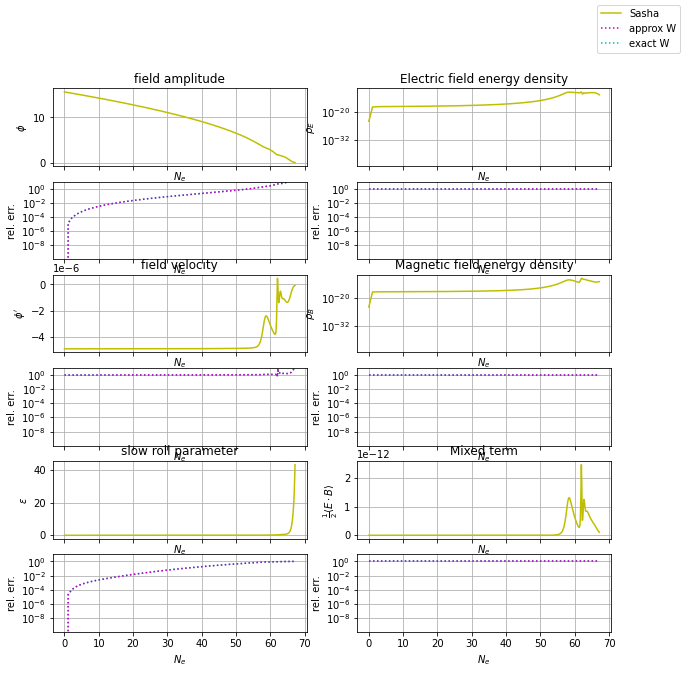

In [23]:
fig, ax = plt.subplots(6,2, figsize=(10,10), sharex=True)

#ax[0,0].plot(sol2.y[0,:], sol2.y[1,:], "g:", label="chaotic inflation")

#ax[2,0].plot(sol2.y[0,:], sol2.y[2,:], "g:", label="chaotic inflation")

#ax[4,0].plot(sol2.y[0,:], 1/sol2.y[1,:]**2, "g:", label="chaotic inflation")



ax[0,0].plot(data[:,0], data[:,1], "y-", label="Sasha")

ax[2,0].plot(data[:,0], data[:,2], "y-", label="Sasha")

ax[4,0].plot(data[:,0], 1/data[:,1]**2, "y-", label="Sasha")

ax[0,1].plot(data[:,0], 0.5*data[:,3], "y-", label="Sasha")

ax[2,1].plot(data[:,0], 0.5*data[:,4], "y-", label="Sasha")

ax[4,1].plot(data[:,0], 0.5*abs(data[:,5]), "y-", label="Sasha")


col = "m:"#, "g:", "c:", "m:"]
    
ax[0,0].plot(solA.y[0,:], solA.y[1,:]*f, col, label="approx W")
ax[2,0].plot(solA.y[0,:], solA.y[2,:]*f*omega, col, label="approx")
ax[4,0].plot(solA.y[0,:], 1/(solA.y[1,:]*f)**2, col, label="approx")
    
ax[0,1].plot(solA.y[0,:], 0.5*solA.y[4,:]*omega**4, col, label="approx")
ax[2,1].plot(solA.y[0,:], 0.5*solA.y[5,:]*omega**4, col, label="approx")
ax[4,1].plot(solA.y[0,:], 0.5*abs(solA.y[6,:])*omega**4, col, label="approx")

print("plotted")

col= "c:"
    
ax[0,0].plot(solB.y[0,:], solB.y[1,:]*f, col, label="exact W ")
ax[2,0].plot(solB.y[0,:], solB.y[2,:]*f*omega, col, label="exact")
ax[4,0].plot(solB.y[0,:], 1/(solB.y[1,:]*f)**2, col, label="exact")
    
ax[0,1].plot(solB.y[0,:], 0.5*solB.y[4,:]*omega**4, col, label="exact")
ax[2,1].plot(solB.y[0,:], 0.5*solB.y[5,:]*omega**4, col, label="exact")
ax[4,1].plot(solB.y[0,:], abs(0.5*solB.y[6,:])*omega**4, col, label="exact")


ax[0,1].set_title("Electric field energy density")
ax[0,1].set_ylabel(r"$\rho_E$")
ax[0,1].set_xlabel(r"$N_e$")
ax[0,1].set_yscale("log")
#ax[0,1].legend(loc=0)

ax[2,1].set_title("Magnetic field energy density")
ax[2,1].set_ylabel(r"$\rho_B$")
ax[2,1].set_xlabel(r"$N_e$")
ax[2,1].set_yscale("log")
#ax[2,1].legend(loc=0)

ax[4,1].set_title("Mixed term")
ax[4,1].set_ylabel(r"$\frac{1}{2}\langle E \cdot B \rangle$")
ax[4,1].set_xlabel(r"$N_e$")
#ax[4,1].set_yscale("log")
#ax[4,1].legend(loc=0)

ax[2,0].set_title("field velocity")
ax[2,0].set_ylabel(r"$\phi'$")
ax[2,0].set_xlabel(r"$N_e$")
#ax[2,0].legend(loc=0)

ax[0,0].set_title("field amplitude")
ax[0,0].set_ylabel(r"$\phi$")
ax[0,0].set_xlabel(r"$N_e$")
#ax[0,0].legend(loc=0)

ax[4,0].set_title("slow roll parameter")
ax[4,0].set_ylabel(r"$\epsilon$")
ax[4,0].set_xlabel(r"$N_e$")
#ax[4,0].legend(loc=0)

from scipy.interpolate import CubicSpline

spl = CubicSpline(solA.y[0,:], solA.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl(data[:,0])/data[:,1]-1), "c:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[1,:]*f)
ax[1,0].plot(data[:,0], abs(spl(data[:,0])/data[:,1]-1), "m:", label="exact err")
"""
spl = CubicSpline(data[:,0], data[:,1])
ax[1,0].plot(solA.y[0,:], abs(solA.y[1,:]*f/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
ax[1,0].plot(solB.y[0,:], abs(solB.y[1,:]*f/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")
"""
ax[1,0].set_ylabel("rel. err.")
ax[1,0].set_xlabel(r"$N_e$")
ax[1,0].set_yscale("log")
#ax[1,0].legend(loc=0)


spl = CubicSpline(solA.y[0,:], solA.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl(data[:,0])/data[:,2]-1), "c:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[2,:]*f*omega)
ax[3,0].plot(data[:,0], abs(spl(data[:,0])/data[:,2]-1), "m:", label="exact err")
"""
spl = CubicSpline(data[:,0], data[:,2])
ax[3,0].plot(solA.y[0,:], abs(solA.y[2,:]*f*omega/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
ax[3,0].plot(solB.y[0,:], abs(solB.y[2,:]*f*omega/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")
"""
ax[3,0].set_ylabel("rel. err.")
ax[3,0].set_xlabel(r"$N_e$")
ax[3,0].set_yscale("log")

spl = CubicSpline(solA.y[0,:], 1/(solA.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl(data[:,0])*data[:,1]**2-1), "c:", label="approx err")
spl = CubicSpline(solB.y[0,:], 1/(solB.y[1,:]*f)**2)
ax[5,0].plot(data[:,0], abs(spl(data[:,0])*data[:,1]**2-1), "m:", label="exact err")

"""spl = CubicSpline(data[:,0], 1/data[:,1]**2)
ax[5,0].plot(solA.y[0,:], abs(1/(spl(solA.y[0,:])*solA.y[1,:]**2)-1), "b:", label="opp. int. apx")
ax[5,0].plot(solB.y[0,:], abs(1/(spl(solB.y[0,:])*solB.y[1,:]**2)-1), "r:", label="opp. int. ex")
"""
ax[5,0].set_ylabel("rel. err.")
ax[5,0].set_xlabel(r"$N_e$")
ax[5,0].set_yscale("log")
#ax[5,0].legend(loc=0)

spl = CubicSpline(solA.y[0,:], solA.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl(data[:,0])/data[:,3]-1), "c:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[4,:]*omega**4)
ax[1,1].plot(data[:,0], abs(spl(data[:,0])/data[:,3]-1), "m:", label="exact err")

"""spl = CubicSpline(data[:,0], data[:,3])
ax[1,1].plot(solA.y[0,:], abs(solA.y[4,:]*omega**4/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
ax[1,1].plot(solB.y[0,:], abs(solB.y[4,:]*omega**4/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")
"""
ax[1,1].set_ylabel("rel. err.")
ax[1,1].set_xlabel(r"$N_e$")
ax[1,1].set_yscale("log")
#ax[1,1].legend(loc=0)


spl = CubicSpline(solA.y[0,:], solA.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl(data[:,0])/data[:,4]-1), "c:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[5,:]*omega**4)
ax[3,1].plot(data[:,0], abs(spl(data[:,0])/data[:,4]-1), "m:", label="exact err")

"""spl = CubicSpline(data[:,0], data[:,4])
ax[3,1].plot(solA.y[0,:], abs(solA.y[5,:]*omega**4/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
ax[3,1].plot(solB.y[0,:], abs(solB.y[5,:]*omega**4/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")"""

ax[3,1].set_ylabel("rel. err.")
ax[3,1].set_xlabel(r"$N_e$")
ax[3,1].set_yscale("log")
#ax[3,1].legend(loc=0)


spl = CubicSpline(solA.y[0,:], solA.y[6,:]*omega**4)
#ax[4,1].plot(data[:,0], 0.5*spl(data[:,0]), "r-")
ax[5,1].plot(data[:,0], abs(spl(data[:,0])/data[:,5]-1), "c:", label="approx err")
spl = CubicSpline(solB.y[0,:], solB.y[6,:]*omega**4)
ax[5,1].plot(data[:,0], abs(spl(data[:,0])/data[:,5]-1), "m:", label="exact err")

"""spl = CubicSpline(data[:,0], data[:,5])
ax[5,1].plot(solA.y[0,:], abs(solA.y[6,:]*omega**4/spl(solA.y[0,:])-1), "b:", label="opp. int. apx")
ax[5,1].plot(solB.y[0,:], abs(solB.y[6,:]*omega**4/spl(solB.y[0,:])-1), "r:", label="opp. int. ex")"""

ax[5,1].set_ylabel("rel. err.")
ax[5,1].set_xlabel(r"$N_e$")
ax[5,1].set_yscale("log")
#ax[5,1].legend(loc=0)
lines_labels = [ax[0,0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

#for a in fig.axes:
 #   a.set_xlim(0.5,65)
a = np.arange(0, 10, 2)
print(a)
ax[1, 0].set_yticks(10.**(-a))
ax[3, 0].set_yticks(10.**(-a))
ax[5, 0].set_yticks(10.**(-a))
ax[1, 1].set_yticks(10.**(-a))
ax[3, 1].set_yticks(10.**(-a))
ax[5, 1].set_yticks(10.**(-a))

ax[1, 0].set_ylim(10.**(-10), 10**1)
ax[3, 0].set_ylim(10.**(-10), 10**1)
ax[5, 0].set_ylim(10.**(-10), 10**1)
ax[1, 1].set_ylim(10.**(-10), 10**1)
ax[3, 1].set_ylim(10.**(-10), 10**1)
ax[5, 1].set_ylim(10.**(-10), 10**1)
for ax in fig.axes:
    ax.grid(True)
plt.show()

## Anber-Sorbo Setup

In [12]:
def EBGnIntegrand(k, xi, a, HConst, n):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*xi)

    Whitt1Plus = whitw(-xi*(1j), 1/2, -2j*k/(a*HConst))
    Whitt2Plus = whitw(1-xi*(1j), 1/2, -2j*k/(a*HConst))
    
    Whitt1Minus = whitw(xi*(1j), 1/2, -2j*k/(a*HConst))
    Whitt2Minus = whitw(1+xi*(1j), 1/2, -2j*k/(a*HConst))
    
    EtermPlus = abs((1j*k/(a*HConst) - 1j*xi) * Whitt1Plus + Whitt2Plus)**2
    EtermMinus = abs((1j*k/(a*HConst) + 1j*xi) * Whitt1Minus + Whitt2Minus)**2
    
    BtermPlus = abs(Whitt1Plus)**2
    BtermMinus = abs(Whitt1Minus)**2
    
    GtermPlus = (Whitt2Plus*Whitt1Plus.conjugate()).real
    GtermMinus = (Whitt2Minus*Whitt1Minus.conjugate()).real
    
    #ErotnE = int(Edk)
    E = k**(1+n) * a**(-n-2) * HConst**2/(4*np.pi**2) * (expterm[0]*EtermPlus + (-1)**n * expterm[1]*EtermMinus)
    
    #BrotnB = int(Bdk)
    B = k**(3+n) * a**(-n-4) / (4*np.pi**2) * (expterm[0]*BtermPlus + (-1)**n * expterm[1]*BtermMinus)
    
    #-ErotnB = int(Gdk)
    G =  k**(2+n) * a**(-n-3) * HConst**2/(4*np.pi**2 ) * (expterm[0]*GtermPlus - (-1)**n * expterm[1]*GtermMinus)
    return E, B, G

def ComputeEBGn(xi, a, HConst, n):
    
    E = lambda k: EBGnIntegrand(k, xi, a, HConst, n)[0]
    B = lambda k: EBGnIntegrand(k, xi, a, HConst, n)[1]
    G = lambda k: EBGnIntegrand(k, xi, a, HConst, n)[2]
    
    kh = 2*a*HConst*abs(xi)
    
    En = quad(E, 0, kh)[0]
    Bn = quad(B, 0, kh)[0]
    Gn = quad(G, 0, kh)[0]
    
    return En, Bn, Gn

def ConstPotentialSlope(xi, G, HConst, Iterm):
    return -(2*(3-alpha)*HConst**2*xi/Iterm + Iterm*G)

def SetupConstH(xi, HConst, a, ntr, file=None):
    y = np.zeros(2+3*ntr)
    
    y[0] = xi
    y[1] = np.log(2*a*HConst*abs(xi))
    
    if(file==None):
        F = np.zeros((ntr, 3))
        for i in range(ntr):
            F[i,:] = ComputeEBGn(xi, a, HConst, i)
            print(str(int(3*(i+1))) + " out of " + str(int(3*ntr)) + " bilinear terms computed")

        DataDic = dict(E = list(F[:,0]), B = list(F[:,1]), G = list(F[:,2]))
        
        output_df = pd.DataFrame(DataDic)  
        filename = "ConstH_xi" + str(xi) + "_Initialiser.dat"
        output_df.to_csv(filename)
        
            
    else:
        input_df = pd.read_table(file, sep=",")
        data = input_df.values
        if (np.shape(data)[0]<ntr):
            nprog = np.shape(data)[0]
            print("need to compute "+str(int(3*(ntr-nprog))) + " more bilinear terms")
            F = np.zeros((ntr, 3))
            F[:nprog,0] = data[:,1].T
            F[:nprog,1] = data[:,2].T
            F[:nprog,2] = data[:,3].T
            
            for i in range(nprog, ntr):
                F[i,:] = ComputeEBGn(xi, a, HConst, i)
                print(str(int(3*(i+1-nprog))) + " out of " + str(int(3*(ntr-nprog))) + " bilinear terms computed")

            DataDic = dict(E = list(F[:,0]), B = list(F[:,1]), G = list(F[:,2]))
        
            output_df = pd.DataFrame(DataDic)  
            output_df.to_csv(file)
        else:
            F = np.array([data[:ntr,1], data[:ntr,2], data[:ntr,3]]).T
        
    y[2:] = F.reshape(3*ntr)
    
    Iterm = beta/Mpl
    
    Vprime = ConstPotentialSlope(xi, F[0,2], HConst, Iterm)
    
    return y, Vprime
    

In [56]:
HConst = 1
xi = -1
beta = 20
Mpl = 0.5e7*(beta/100)**(1/2)*np.exp(2.85*(xi-7))*HConst
yini, dVini = SetupConstH(xi, HConst, 1, 190, file="ConstH_xi-1_Initialiser.dat")


In [57]:
print(yini[3])
steps = int(1e6)
N = np.linspace(0, 50, steps)
t = N/HConst
print(t[0])
print(t[-1])
t = t - t[0]
#print(yini)

func = lambda t, x: ConstHGEF(x, t, HConst, dVini, beta/Mpl)
#print(dVini)
#print(yini[2:5])
#print(yini[5:8])
#dydtini = func(0, yini)
#print("out: ", dydtini[2:5])

3.469387367332456e-01
0.0
50.0


In [58]:
print(np.shape(yini.T))

sol = solve_ivp(func, [t[0], t[-1]] , yini)

(572,)
[ 0.25007448  0.34693874 -0.11533163]
-2.802662578282356e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.25007447  0.34693872 -0.11530764]
-2.802662578282356e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.25007447  0.34693871 -0.11528458]
-2.802662578282356e-05 71360.71304115828 1.0
what abound monotonicity?
[13.66953003 19.23640586  3.05572116]
-4.98062502616404e-04 71360.71304115828 1.0
what abound monotonicity?
[6.75991551e+10 2.40522068e+11 2.24156817e+10]
-5.0059493924542113e+02 71360.71304115828 1.0
what abound monotonicity?
[-3.37892147e+37 -1.24580749e+40 -1.37694334e+37]
2.8942933045637225e+11 71360.71304115828 1.0
[-3.76639540e+90 -1.15739018e+96 -1.53762115e+90]
-1.6722660150391763e+38 7.136071304115828e+04 1.0
what abound monotonicity?
[ 2.99006314e+129 -5.17508694e+102  1.12533237e+135]
8.940154001401999e+90 7.136071304115828e+04 1.0
[ 0.25007448  0.34693873 -0.11532222]
-2.802662578282356e-05 71360.71304115828 1.0
what abound monotonicity?
[0.78685

/tmp/ipykernel_4530/2613948549.py:44: RuntimeWarning: overflow encountered in exp
  kh, dydt[1], bdrF = BoundaryComputations(np.exp(y[1]), dphidt, ddphiddt, dIdsc, 0., a, H, ntr)
/tmp/ipykernel_4530/4231178277.py:20: RuntimeWarning: overflow encountered in exp
  exptermMinus = np.exp(-np.pi*xi)
/tmp/ipykernel_4530/4231178277.py:54: RuntimeWarning: overflow encountered in double_scalars
  bdrF[i, 0] = prefac*scale*(EtermPlus + (-1)**i * EtermMinus)
/tmp/ipykernel_4530/4231178277.py:55: RuntimeWarning: overflow encountered in double_scalars
  bdrF[i, 1] = prefac*scale*(BtermPlus + (-1)**i * BtermMinus)
/tmp/ipykernel_4530/4231178277.py:56: RuntimeWarning: overflow encountered in double_scalars
  bdrF[i, 2] = prefac*scale*(GtermPlus - (-1)**i * GtermMinus)
/tmp/ipykernel_4530/4231178277.py:52: RuntimeWarning: overflow encountered in double_scalars
  scale = (kh/a)**(i+4)
/tmp/ipykernel_4530/718775943.py:22: RuntimeWarning: overflow encountered in double_scalars
  + a**(alpha)*(F[n+1,0] - 

[ 0.32663623  0.4559955  -0.09712907]
-3.0396844997828543e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.32842614  0.45857262 -0.09670116]
-3.0446188294603352e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.32828934  0.45837432 -0.09673398]
-3.0442718234690334e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.33156995  0.46309943 -0.09594955]
-3.0532823875576815e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.33339949  0.46573918 -0.09551169]
-3.058215236177645e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.34294562  0.47952344 -0.09322612]
-3.083747689778879e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.34491072  0.48236627 -0.09275518]
-3.088897817840878e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.34722512  0.48571363 -0.0922006 ]
-3.0949834956006134e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.34703184  0.48543216 -0.09224708]
-3.094518120296027e-05 71360.71304115828 1.0
what abound monotonicity?
[ 0.33113848  

[1.40493881 2.1262216  0.17023883]
-4.54012719057898e-05 71360.71304115828 1.0
what abound monotonicity?
[1.4147324  2.14209217 0.17272168]
-4.5483416163749754e-05 71360.71304115828 1.0
what abound monotonicity?
[1.46461522 2.22298719 0.18537228]
-4.589888896149919e-05 71360.71304115828 1.0
what abound monotonicity?
[1.474048   2.23831552 0.18776683]
-4.5975875804727744e-05 71360.71304115828 1.0
what abound monotonicity?
[1.48570726 2.25726216 0.19072658]
-4.607107123838827e-05 71360.71304115828 1.0
what abound monotonicity?
[1.48541889 2.2567842  0.19065267]
-4.6069233747118804e-05 71360.71304115828 1.0
what abound monotonicity?
[1.50525711 2.28903435 0.19568962]
-4.623060471761172e-05 71360.71304115828 1.0
what abound monotonicity?
[1.51577765 2.30617661 0.19836374]
-4.631427865629631e-05 71360.71304115828 1.0
what abound monotonicity?
[1.56935473 2.39354005 0.21198675]
-4.673742808391957e-05 71360.71304115828 1.0
what abound monotonicity?
[1.57948042 2.41008482 0.21456391]
-4.681579

[11.60746269 20.62115532  2.89142187]
-7.822978856861712e-05 71360.71304115828 1.0
what abound monotonicity?
[11.69112814 20.78186013  2.91430885]
-7.837187701753145e-05 71360.71304115828 1.0
what abound monotonicity?
[12.11653072 21.59960138  3.03071631]
-7.908940177719599e-05 71360.71304115828 1.0
what abound monotonicity?
[12.19647339 21.75360066  3.05261132]
-7.922157850416832e-05 71360.71304115828 1.0
what abound monotonicity?
[12.29557026 21.94451063  3.079753  ]
-7.938540297580626e-05 71360.71304115828 1.0
what abound monotonicity?
[12.29349705 21.94042473  3.07917964]
-7.938279004595804e-05 71360.71304115828 1.0
what abound monotonicity?
[12.46360618 22.26827072  3.12577863]
-7.966298642118526e-05 71360.71304115828 1.0
what abound monotonicity?
[12.55347097 22.44189245  3.15042107]
-7.98076828012886e-05 71360.71304115828 1.0
what abound monotonicity?
[13.01038825 23.32534964  3.27575516]
-8.053836787628711e-05 71360.71304115828 1.0
what abound monotonicity?
[13.09624894 23.4917

[131.39673762 284.70296494  37.44831762]
-1.4504887567041937e-04 71360.71304115828 1.0
what abound monotonicity?
[132.34849411 286.94036353  37.7294229 ]
-1.453124747313796e-04 71360.71304115828 1.0
what abound monotonicity?
[137.18680872 298.32333198  39.15882674]
-1.4664335718392711e-04 71360.71304115828 1.0
what abound monotonicity?
[138.09537865 300.46560522  39.42745277]
-1.4688834774509668e-04 71360.71304115828 1.0
what abound monotonicity?
[139.22203929 303.12230159  39.76056655]
-1.47192085603065e-04 71360.71304115828 1.0
what abound monotonicity?
[139.19898397 303.06662679  39.7536924 ]
-1.4718736536309713e-04 71360.71304115828 1.0
what abound monotonicity?
[141.13509912 307.63392246  40.32621414]
-1.477074275108668e-04 71360.71304115828 1.0
what abound monotonicity?
[142.15746199 310.05185367  40.62879831]
-1.4797586022625316e-04 71360.71304115828 1.0
what abound monotonicity?
[147.35469838 322.35328028  42.16741571]
-1.4933114430118718e-04 71360.71304115828 1.0
what abound m

[1297.41741702 3410.37814745  396.46133119]
-2.593900674099632e-04 71360.71304115828 1.0
what abound monotonicity?
[1306.83242996 3437.27122137  399.41608969]
-2.598615602468928e-04 71360.71304115828 1.0
what abound monotonicity?
[1354.69226849 3574.08815842  414.43955021]
-2.6224195345718915e-04 71360.71304115828 1.0
what abound monotonicity?
[1363.67820634 3599.83368114  417.26205955]
-2.6268005308476683e-04 71360.71304115828 1.0
what abound monotonicity?
[1374.8222973  3631.76496537  420.76251697]
-2.6322325597058147e-04 71360.71304115828 1.0
what abound monotonicity?
[1374.59564561 3631.09958665  420.69082198]
-2.6321488059141555e-04 71360.71304115828 1.0
what abound monotonicity?
[1393.75184129 3686.01102197  426.70865747]
-2.641452230957768e-04 71360.71304115828 1.0
what abound monotonicity?
[1403.86648335 3715.08018733  429.88844093]
-2.6462536199779426e-04 71360.71304115828 1.0
what abound monotonicity?
[1455.28273867 3862.96776798  446.05600359]
-2.6704940295945486e-04 71360.7

what abound monotonicity?
[11712.41553354 37163.2120359   3773.64297975]
-4.5302832990763405e-04 71360.71304115828 1.0
what abound monotonicity?
[11808.27824908 37493.57908118  3805.20207116]
-4.539651994419402e-04 71360.71304115828 1.0
what abound monotonicity?
[11806.33618183 37486.7203918   3804.55898416]
-4.5395083047028635e-04 71360.71304115828 1.0
what abound monotonicity?
[11971.15134927 38054.95417765  3858.82325664]
-4.5555570162984435e-04 71360.71304115828 1.0
what abound monotonicity?
[12058.17255427 38355.76328333  3887.49163388]
-4.563838879187539e-04 71360.71304115828 1.0
what abound monotonicity?
[12500.5223645  39886.08609599  4033.24682838]
-4.605649514488079e-04 71360.71304115828 1.0
what abound monotonicity?
[12583.56791805 40174.03102869  4060.62465326]
-4.61334353590674e-04 71360.71304115828 1.0
what abound monotonicity?
[12686.56614368 40531.18616647  4094.58085217]
-4.622884012838909e-04 71360.71304115828 1.0
what abound monotonicity?
[12684.4797549  40523.772137

(572, 167)


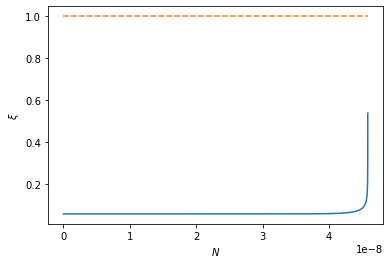

In [59]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, np.log10(abs((sol.y[0,:]-7)/7)))
plt.plot(sol.t, np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 7.0*np.ones(len(sol.t)), "--")
#plt.plot(sol.t, 9.21*np.ones(len(sol.t)), "y--")
#plt.plot(sol.t, 4.79*np.ones(len(sol.t)), "y--")
plt.xlabel(r"$N$")
plt.ylabel(r"$\xi$")
plt.show()

In [93]:
def getNCut(t, xi, xi0, prec=10**(-0.5)):
    for i in range(len(xi)):
        diff = abs(xi[i]-xi0)/xi0
        if (diff > prec):
            return t[i]
    return False

def NCutbyDelta(t, yini, vals, prec=10**(-0.5)):
    xi0 = yini[0]
    print(xi0)
    print(np.arange(1, vals))
    delta = 1/10**(np.arange(1, vals+1))
    xis = (delta+1)*xi0
    print(xis)
    NCut = []
    #delta = []
    for i in range(vals):
        yini[0] = xis[i]
        #sol = solve_ivp(func, [t[0], t[-1]] , yini)
        #NCut.append(getNCut(sol.t, sol.y[0,:], xi0, prec=10**(-0.5)))
    yini[0] = xi0
    delta = list(delta)
    return delta, NCut

def PlotNCutvsDelta(xi0, style="r."):
    file = "NCut_xi_" + str(xi0) + ".dat"
    input_df = pd.read_table(file, sep=",")
    data = input_df.values
    delta = data[:,1]
    NCut = data[:,2]
    plt.plot(delta, NCut, style, label=r"$\Delta N_e$ for $\xi_0=$" + str(xi0))
    plt.xlabel(r"$|\xi-\xi_0|$")
    plt.ylabel(r"$\Delta N_e$")
    plt.legend(loc=0)
    plt.show()
    return

def PlotNCutvsDeltaLog(xi0, I, style="r."):
    filebeg = "NCut_xi_" + str(xi0) + "_del"
    filend = "_I" + str(I) + "_log.dat"
    input_df = pd.read_table(file, sep=",")
    data = input_df.values
    delta = data[:,1]
    NCut = data[:,2]
    plt.plot(np.log10(delta), NCut, style, label=r"$\Delta N_e$ for $\xi_0=$" + str(xi0))
    plt.xlabel(r"$\log_{10}(|\xi-\xi_0|)$")
    plt.ylabel(r"$\Delta N_e$")
    plt.legend(loc=0)
    plt.show()
    return

def ReadFile(xi0, I, delta=None):
    filebeg = "Out_" + str(xi0) "_"
    filend = "_I" + str(I) + "_log.dat"
    if (delta == None):
        filename = filebeg + "base" + filend
    else:
        filename = filebeg + "del" + str(delta) + filend

    pwd = os.getcwd()
    path = os.path.join(pwd, filename)
    file = os.path.exists(path)
    if (not file):
        "There is no such file"
        return
    else:
        input_df = pd.read_table(file, sep=",")
        data = input_df.values
        t = data[:,1]
        y = data[:,2:]
    return t, y

In [63]:
print(NCutbyDelta(t, yini, 10))

7.000000007000001
[1 2 3 4 5 6 7 8 9]
[7.70000001 7.07000001 7.00700001 7.00070001 7.00007001 7.00000701
 7.00000071 7.00000008 7.00000001 7.00000001]
([0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10], [])


In [99]:
#Plus Sol
print(getNCut(sol.t, sol.y[0,:], 7.0))

1.0778432079856222e+01


In [94]:
print(getNCut(sol.t, sol.y[0,:], 7.0))

8.812767894971508e+00


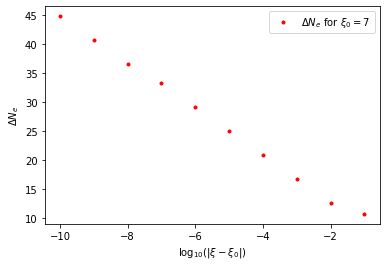

In [65]:
PlotNCutvsDeltaLog(7)

(596, 3671)


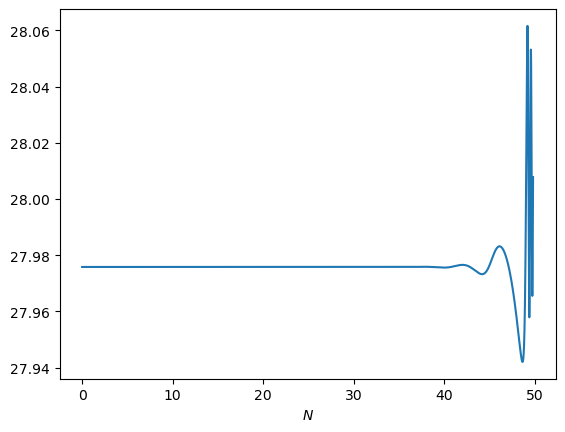

In [31]:
print(np.shape(sol.y))
#print(sol.y[2,:])
plt.plot(sol.t, np.log(abs(sol.y[4,:])))
plt.xlabel(r"$N$")
plt.show()

In [98]:
def ComputeEEBB(x, a, H):
    kh = 2*a*H*x
    
    f = lambda k: GetIntEEBB(k, x, a, H)
    
    EEBB = quad(f, 0, kh)[0]
    return EEBB

def ComputeEB(x, a, H):
    kh = 2*a*H*x
    
    f = lambda k: GetIntEEBB(k, x, a, H)
    
    EB = quad(f, 0, kh)[0]
    return EB

def GetIntEB(k, x, a, H):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*x)
    
    Whitt1Plus = whitw(-x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Plus = whitw(1-x*(1j), 1/2, -2j*k/(a*H))
    
    Whitt1Minus = whitw(x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Minus = whitw(1+x*(1j), 1/2, -2j*k/(a*H))
    
    GtermPlus = (Whitt2Plus*Whitt1Plus.conjugate()).real
    GtermMinus = (Whitt2Minus*Whitt1Minus.conjugate()).real
    
    return k**2 * a**-3 * H/(4*np.pi**2 ) * (expterm[0]*GtermPlus
                                             - expterm[1]*GtermMinus)

def GetIntEEBB(k, x, a, H):
    lam = np.array([1, -1])
    expterm = np.exp(lam*np.pi*x)
    
    Whitt1Plus = whitw(-x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Plus = whitw(1-x*(1j), 1/2, -2j*k/(a*H))
    
    Whitt1Minus = whitw(x*(1j), 1/2, -2j*k/(a*H))
    Whitt2Minus = whitw(1+x*(1j), 1/2, -2j*k/(a*H))
    
    EtermPlus = abs((1j*k/(a*H) - 1j*x) * Whitt1Plus + Whitt2Plus)**2
    EtermMinus = abs((1j*k/(a*H) - 1j*x) * Whitt1Minus + Whitt2Minus)**2
    
    BtermPlus = abs(Whitt1Plus)**2
    BtermMinus = abs(Whitt1Minus)**2
    
    E = k * a**-2 * H/(4*np.pi**2) * (expterm[0]*EtermPlus
                                             + expterm[1]*EtermMinus)
    B = k**3 * a**-4 * H/(4*np.pi**2) * (expterm[0]*EtermPlus
                                             + expterm[1]*EtermMinus)
    
    return (E + B)/2

In [99]:
ComputeEB(1, 1, 1)/(np.exp(2*np.pi))
ComputeEEBB(1, 1, 1)/(np.exp(2*np.pi))

0.002005904173288318

In [85]:
H = 1
a = 1


EBcut = lambda x: ComputeEB(x, a, H)/(np.exp(2*np.pi*x)/x**4)

x = np.linspace(1, 100, 100)

EBapprox = np.ones(x.size)*(2.6e-4*H**4)

Eres = np.array([EBcut(x[i]) for i in range(x.size)]) 



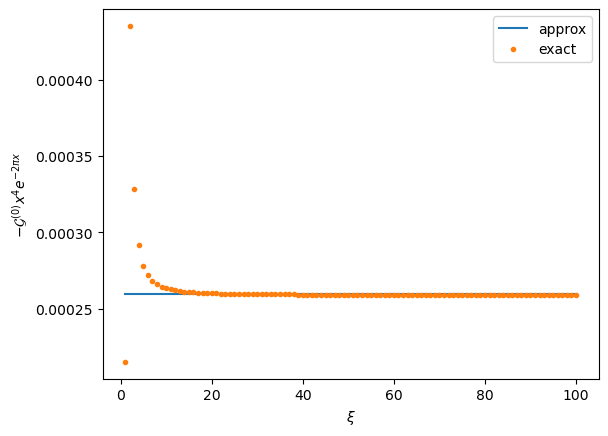

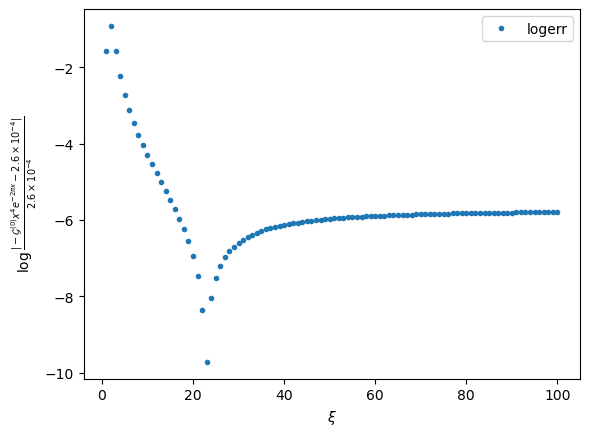

In [113]:
#plt.plot(x, EBapprox, ".", label="Approx")
#plt.plot(x, Eres, ".", label="exact")
plt.plot(x, EBapprox, label="approx")
plt.plot(x, Eres, ".", label="exact")
plt.legend(loc=0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$-\mathcal{G}^{(0)} x^4 e^{-2 \pi x}$")
plt.show()
plt.plot(x, np.log(abs(EBapprox-Eres)/abs(Eres)), ".", label="logerr")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\log \frac{|-\mathcal{G}^{(0)} x^4 e^{-2 \pi x} - 2.6 \times 10^{-4}|}{2.6 \times 10^{-4}}$")
plt.legend(loc=0)
plt.show()

In [100]:
EEBBcut = lambda x: ComputeEEBB(x, a, H)/(np.exp(2*np.pi*x)/x**3)

x = np.linspace(1, 100, 100)

EEBBapprox = np.ones(x.size)*(1.4e-4*H**4)

EEBBres = np.array([EEBBcut(x[i]) for i in range(x.size)]) 


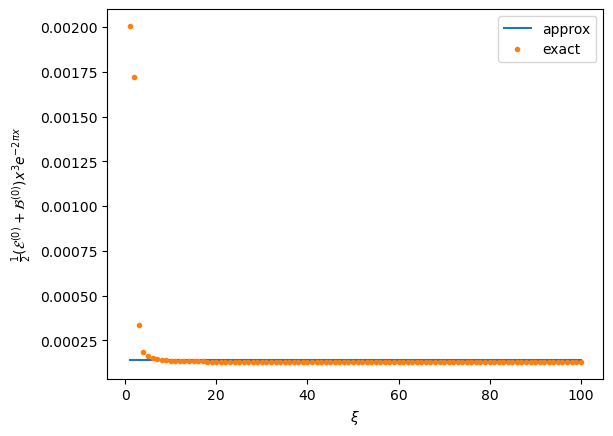

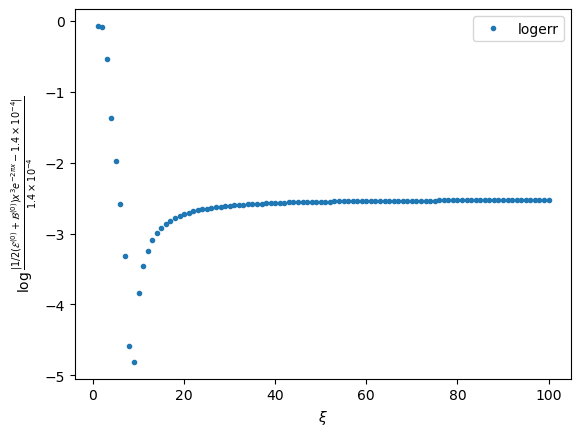

In [117]:
#plt.plot(x, EBapprox, ".", label="Approx")
#plt.plot(x, Eres, ".", label="exact")
plt.plot(x, EEBBapprox, label="approx")
plt.plot(x, EEBBres, ".", label="exact")
plt.legend(loc=0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\frac{1}{2}(\mathcal{E}^{(0)} + \mathcal{B}^{(0)}) x^3 e^{-2 \pi x}$")
plt.show()
plt.plot(x, np.log(abs(EEBBapprox-EEBBres)/abs(EEBBres)), ".", label="logerr")
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\log \frac{|1/2 (\mathcal{E}^{(0)} + \mathcal{B}^{(0)}) x^3 e^{-2 \pi x}- 1.4 \times 10^{-4}|}{1.4 \times 10^{-4}}$")
plt.legend(loc=0)
plt.show()

In [23]:
comp = yini[2:].reshape(192,3)
comp[:, [1,2]] = comp[:,[2,1]]
data = np.genfromtxt('InitCond_xi7.dat', dtype=float)

def CompareData(N, comp, data):
    x1 = comp
    x2 = data[N, 1:]
    #print(x1)
    #print(x2)
    err = abs((x1-x2)/x2)
    sgn = x1/x2
    return err, sgn

err = np.zeros((comp.shape))
sgn = np.zeros((comp.shape))
for i in range(192):
    err[i,:], sgn[i,:] = CompareData(i, comp[i,:], data)
    
print(err)
print(sgn)

[[1.22551825e-09 1.12831344e-09 9.37223439e-10]
 [1.14314803e-09 8.85938454e-10 4.32646654e-10]
 [8.31348357e-10 2.45508387e-10 7.26026071e-10]
 [1.92389456e-09 1.15275269e-09 3.02113475e-09]
 [1.56837710e-09 3.67614934e-09 7.44625259e-09]
 [2.37948354e-07 7.98032743e-09 1.52766278e-08]
 [9.01332610e-09 1.50761111e-08 3.07870858e-08]
 [2.59758542e-09 2.56157048e-08 4.71519559e-08]
 [3.23659202e-08 3.83040889e-08 6.51343682e-08]
 [9.17906374e-08 4.68078977e-08 5.61004380e-08]
 [6.57617556e-08 4.59984692e-08 4.34541278e-08]
 [1.04700455e-05 3.63798343e-08 2.71934914e-08]
 [2.65801238e-08 2.55038509e-08 1.77859364e-08]
 [6.15745869e-06 1.63392493e-08 9.84999963e-09]
 [9.18144872e-09 1.02913945e-08 5.90604248e-09]
 [3.90383754e-07 6.24336435e-09 3.62115153e-09]
 [2.94963417e-09 3.89469185e-09 1.91634939e-09]
 [2.45608481e-07 2.19975237e-09 1.12351284e-09]
 [1.12587660e-09 1.24206541e-09 5.74817268e-10]
 [3.82454796e-07 6.94780267e-10 3.22745290e-10]
 [5.59758048e-10 3.69146194e-10 1.485344

In [169]:
comp = dydtini[2:].reshape(198,3)
comp[:, [1,2]] = comp[:,[2,1]]
data = np.genfromtxt('Tab_deriv_198.dat', dtype=float)

def CompareData(N, comp, data):
    x1 = comp
    x2 = data[N, 1:]
    #print(x1)
    #print(x2)
    err = abs((x1-x2)/x2)
    sgn = x1/x2
    return err, sgn

err = np.zeros((comp.shape))
sgn = np.zeros((comp.shape))
for i in range(198):
    err[i,:], sgn[i,:] = CompareData(i, comp[i,:], data)
    
print(err)
print(sgn)

[[0.00000000e+00 9.20167932e-01 1.15249905e+01]
 [4.00608926e-05 4.69877919e+00 8.24379094e-01]
 [3.82738494e-04 9.60604803e-01 2.17856176e+01]
 [1.71648164e-01 1.47280967e+00 1.28894590e+00]
 [8.75671527e-01 1.03345199e+00 1.24650732e+00]
 [2.44736842e+00 9.84547490e-01 9.99871523e-01]
 [9.95420815e-01 1.00095079e+00 1.00035789e+00]
 [9.99594844e-01 9.99991709e-01 1.00000428e+00]
 [9.99997263e-01 1.00000000e+00 1.00000012e+00]
 [9.99998525e-01 9.99998734e-01 9.99999185e-01]
 [9.99999940e-01 1.00000029e+00 1.00000014e+00]
 [9.99999890e-01 1.00000001e+00 1.00000015e+00]
 [9.99999990e-01 1.00000107e+00 9.99999865e-01]
 [1.00000004e+00 9.99999814e-01 1.00000007e+00]
 [1.00000732e+00 9.99975840e-01 9.99999651e-01]
 [1.00001192e+00 9.99995895e-01 1.00000340e+00]
 [9.99998990e-01 9.99998629e-01 1.00000031e+00]
 [1.00000058e+00 9.99999889e-01 9.99999921e-01]
 [9.99999954e-01 9.99999956e-01 1.00000001e+00]
 [9.99999965e-01 9.99999969e-01 1.00000001e+00]
 [9.99999986e-01 9.99999959e-01 9.999999

In [31]:
n = np.random.randint(200, 300)
n=26
print(n)
dataN = np.array(ComputeEBGn(7., 1., 1., n))
print(dataN)
print(data[n,1:])
dataN[[1,2]] = dataN[[2,1]]
print(CompareData(n, dataN, data))

26
[3.66679423e+31 1.06650851e+32 1.59509134e+31]
[5.63585790e+23 2.54284819e+25 2.38979299e+23]
(array([6.50618636e+07, 6.27284321e+05, 4.46276522e+08]), array([6.50618646e+07, 6.27285321e+05, 4.46276523e+08]))


In [46]:
Names = ["n", "E", "B", "G"]
Data = yini[2:].reshape(100, 3)

DataDic = dict(E = list(Data[:,0]), B = list(Data[:,1]), G = list(Data[:,2]))
import pandas as pd
output_df = pd.DataFrame(DataDic)  
output_df.to_csv('output_file_name.dat')

input_df = pd.read_table('output_file_name.dat', sep=",") 
print(input_df.values[:,1])

[ 9.65018236e+012  2.49912527e+012  1.04739809e+012  6.52372520e+011
  5.70831966e+011  6.75023998e+011  1.05236970e+012  2.10847385e+012
  5.69972190e+012  1.65052837e+013  1.13111323e+014  1.25428976e+014
  8.83932193e+015 -2.89653393e+016  1.24547152e+018 -7.02762401e+018
  2.04548927e+020 -1.36812834e+021  3.52956063e+022 -2.55064903e+023
  6.23117710e+024 -4.70164605e+025  1.11519034e+027 -8.64701907e+027
  2.01488900e+029 -1.59173356e+030  3.66679423e+031 -2.93611407e+032
  6.71174459e+033 -5.42939507e+034  1.23444736e+036 -1.00656509e+037
  2.27974983e+038 -1.87075957e+039  4.22514428e+040 -3.48519325e+041
  7.85502664e+042 -6.50737121e+043  1.46437779e+045 -1.21755669e+046
  2.73672990e+047 -2.28252020e+048  5.12599555e+049 -4.28669374e+050
  9.62059546e+051 -8.06413070e+052  1.80894639e+054 -1.51939003e+055
  3.40707955e+056 -2.86689151e+057  6.42706853e+058 -5.41678020e+059
  1.21413208e+061 -1.02475621e+062  2.29665335e+063 -1.94094888e+064
  4.34971349e+065 -3.68035487e+066

In [5]:
HoverMpl = lambda beta, xi: 2e-7*(beta/100)**(-1/2)*np.exp(-2.85*(xi-7))

In [8]:
beta = 10**np.array([1.5, 3.5])
xi = np.array([5,9])

In [16]:
HoverMpl(beta, xi)
from scipy.optimize import fsolve
f = lambda x: HoverMpl(x, 7) - 



SyntaxError: invalid syntax (2749062437.py, line 1)

In [1]:
import numpy as np
print(np.arange(1, 16)[1:])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [17]:
2.2e-18*6.58e-16

1.4476e-33

In [23]:
beta = 2.45e-5*1.63e-7

In [21]:
HoverMpl(2.45e-5*1.63e-7, 7)

1.0008134915772269e+00

In [3]:
2.45/4

0.6125

In [8]:
HoverMpl(2.45e-5*6.125e6, 7)

1.63265306122449e-07

In [9]:
1/6.125e6

1.63265306122449e-07

76.0
